### Imports

In [218]:
#basic libraries
import pandas as pd
import numpy as np
from numpy import interp

#NLTK libraries
import nltk
import re
import string
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer

# Machine Learning libraries
import sklearn 
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn import svm, datasets
from sklearn import preprocessing 


#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Other miscellaneous libraries
from itertools import cycle
import cufflinks as cf
from collections import defaultdict
from collections import Counter
from imblearn.over_sampling import SMOTE

### Importing the datasets

In [4]:
reviews = pd.read_csv("C:/Users/Casey/Downloads/Musical_instruments_reviews.csv/Musical_instruments_reviews.csv")
print("The shape of the data (row, column):" + str(reviews.shape))
print(reviews.info())

The shape of the data (row, column):(10261, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10261 entries, 0 to 10260
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   reviewerID      10261 non-null  object 
 1   asin            10261 non-null  object 
 2   reviewerName    10234 non-null  object 
 3   helpful         10261 non-null  object 
 4   reviewText      10254 non-null  object 
 5   overall         10261 non-null  float64
 6   summary         10261 non-null  object 
 7   unixReviewTime  10261 non-null  int64  
 8   reviewTime      10261 non-null  object 
dtypes: float64(1), int64(1), object(7)
memory usage: 721.6+ KB
None


In [5]:
reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]   
1                                              Jake  [13, 14]   
2                     Rick Bennette "Rick Bennette"    [1, 1]   
3                         RustyBill "Sunday Rocker"    [0, 0]   
4                                     SEAN MASLANKA    [0, 0]   

                                          reviewText  overall  \
0  Not much to write about here, but it does exac...      5.0   
1  The product does exactly as it should and is q...      5.0   
2  The primary job of this device is to block the...      5.0   
3  Nice windscreen protects my MXL mic and preven...      5.0   
4  This pop filter is great. It looks and perform...      5.0   

                                 summary  unixReviewTime   reviewTime  
0                                   good      1393545600  02 28, 2014  
1                                   Jake      1363392000  03 16, 2013  
2                   It Does The Job Well      1377648000  08 28, 2013  
3          GOOD WINDSCREEN FOR THE MONEY      1392336000  02 14, 2014  
4  No more pops when I record my vocals.      1392940800  02 21, 2014

### Preprocessing and cleaning

In [7]:
# creating a copy of a dataset
process_reviews = reviews.copy()

# checking for null values 
process_reviews.isna().sum()

reviewerID         0
asin               0
reviewerName      27
helpful            0
reviewText         7
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

##### We got null values in reviewer names and review text. Reviewer names doesn't add any value(we got id's instead) to our objective of the project. review text null values will be replaced by "missing" 

In [9]:
process_reviews['reviewText']=process_reviews['reviewText'].fillna('Missing')

In [10]:
#### Concentating review and summary
process_reviews['reviews']=process_reviews['reviewText']+process_reviews['summary']
process_reviews=process_reviews.drop(['reviewText', 'summary'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews  
0  Not much to write about here, but it does exac...  
1  The product does exactly as it should and is q...  
2  The primary job of this device is to block the...  
3  Nice windscreen protects my MXL mic and preven...  
4  This pop filter is great. It looks and perform...

### Creating "sentiment" column

##### we are creating the outcome column (sentiment of review) based on the overall score. If the score is greater than 3, we take that as positive and if the value is less than 3 it is negative If it is equal to 3, we take that as neutral sentiment

In [13]:
#checking the distribution of categories
process_reviews['overall'].value_counts()

overall
5.0    6938
4.0    2084
3.0     772
2.0     250
1.0     217
Name: count, dtype: int64

In [14]:
def f(row):
    
    '''This function returns sentiment value based on the overall ratings from the user'''
    
    if row['overall'] == 3.0:
        val = 'Neutral'
    elif row['overall'] == 1.0 or row['overall'] == 2.0:
        val = 'Negative'
    elif row['overall'] == 4.0 or row['overall'] == 5.0:
        val = 'Positive'
    else:
        val = -1
    return val

In [15]:
#Applying the function 
process_reviews['sentiment'] = process_reviews.apply(f, axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime   reviewTime  \
0      1393545600  02 28, 2014   
1      1363392000  03 16, 2013   
2      1377648000  08 28, 2013   
3      1392336000  02 14, 2014   
4      1392940800  02 21, 2014   

                                             reviews sentiment  
0  Not much to write about here, but it does exac...  Positive  
1  The product does exactly as it should and is q...  Positive  
2  The primary job of this device is to block the...  Positive  
3  Nice windscreen protects my MXL mic and preven...  Positive  
4  This pop filter is great. It looks and perform...  Positive

In [16]:
process_reviews['sentiment'].value_counts()

sentiment
Positive    9022
Neutral      772
Negative     467
Name: count, dtype: int64

### Handling time column

In [18]:
# new data frame which has date and year
new = process_reviews["reviewTime"].str.split(",", n = 1, expand = True) 
  
# making separate date column from new data frame 
process_reviews["date"]= new[0] 
  
# making separate year column from new data frame 
process_reviews["year"]= new[1] 

process_reviews=process_reviews.drop(['reviewTime'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   date   year  
0  Positive  02 28   2014  
1  Positive  03 16   2013  
2  Positive  08 28   2013  
3  Positive  02 14   2014  
4  Positive  02 21   2014

In [19]:
# Splitting the date 
new1 = process_reviews["date"].str.split(" ", n = 1, expand = True) 
  
# adding month to the main dataset 
process_reviews["month"]= new1[0] 
  
# adding day to the main dataset 
process_reviews["day"]= new1[1] 

process_reviews=process_reviews.drop(['date'], axis=1)
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName   helpful  overall  \
0  cassandra tu "Yeah, well, that's just like, u...    [0, 0]      5.0   
1                                              Jake  [13, 14]      5.0   
2                     Rick Bennette "Rick Bennette"    [1, 1]      5.0   
3                         RustyBill "Sunday Rocker"    [0, 0]      5.0   
4                                     SEAN MASLANKA    [0, 0]      5.0   

   unixReviewTime                                            reviews  \
0      1393545600  Not much to write about here, but it does exac...   
1      1363392000  The product does exactly as it should and is q...   
2      1377648000  The primary job of this device is to block the...   
3      1392336000  Nice windscreen protects my MXL mic and preven...   
4      1392940800  This pop filter is great. It looks and perform...   

  sentiment   year month day  
0  Positive   2014    02  28  
1  Positive   2013    03  16  
2  Positive   2013    08  28  
3  Positive   2014    02  14  
4  Positive   2014    02  21

### FInding the helpfulness of the review

In [21]:
# Splitting the dataset based on comma and square bracket 
new1 = process_reviews["helpful"].str.split(",", n = 1, expand = True)
new2 = new1[0].str.split("[", n = 1, expand = True)
new3 = new1[1].str.split("]", n = 1, expand = True)

#Resetting the index
new2.reset_index(drop=True, inplace=True)
new3.reset_index(drop=True, inplace=True)

#Dropping empty columns due to splitting 
new2=new2.drop([0], axis=1)
new3=new3.drop([1], axis=1)

#Concatenating the splitted columns
helpful=pd.concat([new2, new3], axis=1)


# I found few spaces in new3, so it is better to strip all the values to find the rate
def trim_all_columns(df):
    """
    Trim whitespace from ends of each value across all series in dataframe
    """
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.applymap(trim_strings)

#Applying the function
helpful= trim_all_columns(helpful)

#Converting into integer types
helpful[0]=helpful[0].astype(str).astype(int)
helpful[1]=helpful[1].astype(str).astype(int)

#Dividing the two columns, we have 0 in the second columns when dvided gives error, so I'm ignoring those errors
try:
  helpful['result'] = helpful[1]/helpful[0]
except ZeroDivisionError:
  helpful['result']=0

#Filling the NaN values(created due to dividing) with 0
helpful['result'] = helpful['result'].fillna(0)

#Rounding of the results to two decimal places
helpful['result']=helpful['result'].round(2) 

#Attaching the results to a new column of the main dataframe
process_reviews['helpful_rate']=helpful['result']

#dropping the helpful column from main dataframe
process_reviews=process_reviews.drop(['helpful'], axis=1)

In [22]:
process_reviews.head()

reviewerID        asin  \
0  A2IBPI20UZIR0U  1384719342   
1  A14VAT5EAX3D9S  1384719342   
2  A195EZSQDW3E21  1384719342   
3  A2C00NNG1ZQQG2  1384719342   
4   A94QU4C90B1AX  1384719342   

                                       reviewerName  overall  unixReviewTime  \
0  cassandra tu "Yeah, well, that's just like, u...      5.0      1393545600   
1                                              Jake      5.0      1363392000   
2                     Rick Bennette "Rick Bennette"      5.0      1377648000   
3                         RustyBill "Sunday Rocker"      5.0      1392336000   
4                                     SEAN MASLANKA      5.0      1392940800   

                                             reviews sentiment   year month  \
0  Not much to write about here, but it does exac...  Positive   2014    02   
1  The product does exactly as it should and is q...  Positive   2013    03   
2  The primary job of this device is to block the...  Positive   2013    08   
3  Nice windscreen protects my MXL mic and preven...  Positive   2014    02   
4  This pop filter is great. It looks and perform...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

In [23]:
process_reviews['helpful_rate'].value_counts()

helpful_rate
0.00    7215
1.00    2040
0.50     266
0.67     136
0.75     111
        ... 
0.56       1
0.15       1
0.13       1
0.43       1
0.69       1
Name: count, Length: 65, dtype: int64

##### 0.00 indicates that the review hasn't been much helpful and 1.00 indicates that the review has been very helpful

### Review text-Punctuation Cleaning

In [26]:
#Removing unnecessary columns
process_reviews=process_reviews.drop(['reviewerName','unixReviewTime'], axis=1)
#Creating a copy 
clean_reviews=process_reviews.copy()

In [27]:
import re
import string

def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets, remove links, remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()  # Convert to string and make lowercase
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove URLs
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

In [260]:
process_reviews['reviews']=process_reviews['reviews'].apply(lambda x:review_cleaning(x))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews  sentiment   year month  \
0  not much write here but exactly supposed to fi...          2   2014    02   
1  the product exactly quite affordablei not real...          2   2013    03   
2  the primary job device block breath would othe...          2   2013    08   
3  nice windscreen protects mxl mic prevents pops...          2   2014    02   
4  this pop filter great it looks performs like s...          2   2014    02   

  day  helpful_rate  polarity  review_len  word_count  
0  28          0.00  0.250000         179          28  
1  16          0.93  0.052778         381          59  
2  28          1.00  0.167500         345          54  
3  14          0.00  0.250000         184          25  
4  21          0.00  0.800000         144          23

In [29]:
### Review text stop words

In [30]:
stop_words= ['yourselves', 'between', 'whom', 'itself', 'is', "she's", 'up', 'herself', 'here', 'your', 'each', 
             'we', 'he', 'my', "you've", 'having', 'in', 'both', 'for', 'themselves', 'are', 'them', 'other',
             'and', 'an', 'during', 'their', 'can', 'yourself', 'she', 'until', 'so', 'these', 'ours', 'above', 
             'what', 'while', 'have', 're', 'more', 'only', "needn't", 'when', 'just', 'that', 'were', "don't", 
             'very', 'should', 'any', 'y', 'isn', 'who',  'a', 'they', 'to', 'too', "should've", 'has', 'before',
             'into', 'yours', "it's", 'do', 'against', 'on',  'now', 'her', 've', 'd', 'by', 'am', 'from', 
             'about', 'further', "that'll", "you'd", 'you', 'as', 'how', 'been', 'the', 'or', 'doing', 'such',
             'his', 'himself', 'ourselves',  'was', 'through', 'out', 'below', 'own', 'myself', 'theirs', 
             'me', 'why', 'once',  'him', 'than', 'be', 'most', "you'll", 'same', 'some', 'with', 'few', 'it',
             'at', 'after', 'its', 'which', 'there','our', 'this', 'hers', 'being', 'did', 'of', 'had', 'under',
             'over','again', 'where', 'those', 'then', "you're", 'i', 'because', 'does', 'all']

In [31]:
process_reviews['reviews'] = process_reviews['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  Not much write here, but exactly supposed to. ...  Positive   2014    02   
1  The product exactly quite affordable.I not rea...  Positive   2013    03   
2  The primary job device block breath would othe...  Positive   2013    08   
3  Nice windscreen protects MXL mic prevents pops...  Positive   2014    02   
4  This pop filter great. It looks performs like ...  Positive   2014    02   

  day  helpful_rate  
0  28          0.00  
1  16          0.93  
2  28          1.00  
3  14          0.00  
4  21          0.00

### Exploratory Data Analysis

#### Story Generation and Visualization from reviews

#### Sentiment VS Helpful rate

In [35]:
pd.DataFrame(process_reviews.groupby('sentiment')['helpful_rate'].mean())

helpful_rate
sentiment              
Negative       0.307559
Neutral        0.275687
Positive       0.260505

#### From the table we can see that the mean of of helpful rate is higher for any negative reviews than neutral and positive reviews. These mean value might have been influenced by the 0 values in helpful rates. Lets check how it is distributed through violin plot

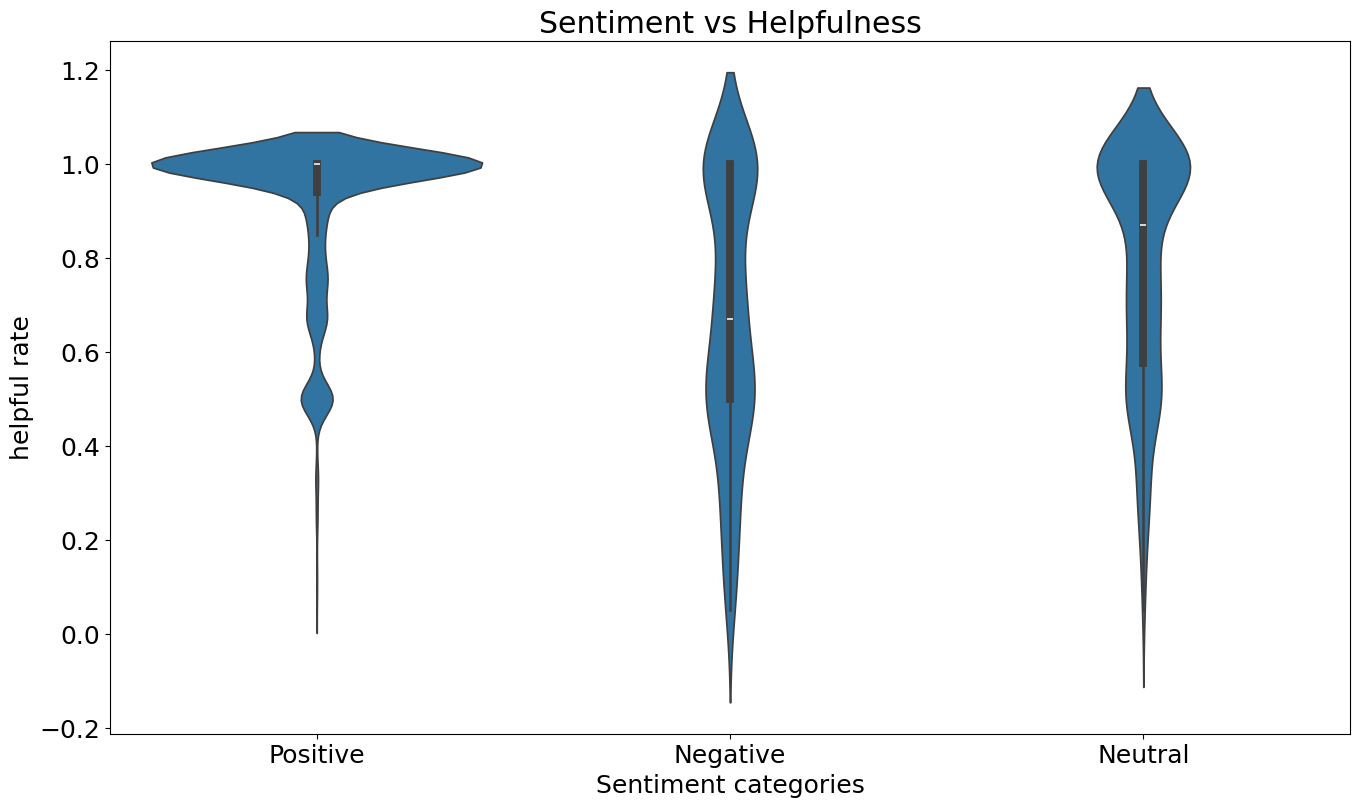

In [37]:
#plot layout 
plt.rcParams.update({'font.size': 18})
rcParams['figure.figsize'] = 16,9

#creating dataframe and removing 0 from helpfulrate records 
senti_help= pd.DataFrame(process_reviews, columns = ['sentiment', 'helpful_rate'])
senti_help = senti_help[senti_help['helpful_rate'] != 0.00] 

#Plotting phase
sns.violinplot( x=senti_help["sentiment"], y=senti_help["helpful_rate"])
plt.title('Sentiment vs Helpfulness')
plt.xlabel('Sentiment categories')
plt.ylabel('helpful rate')
plt.show()

##### Insights:

##### From the plot we can declare that more number of positive reviews are having high helpful rate. We got deceived by the mean value, it's better to look at a plot rather than taking some measures of central tendency under such situation. Our first assumption is correct !

### Year vs sentiment count 

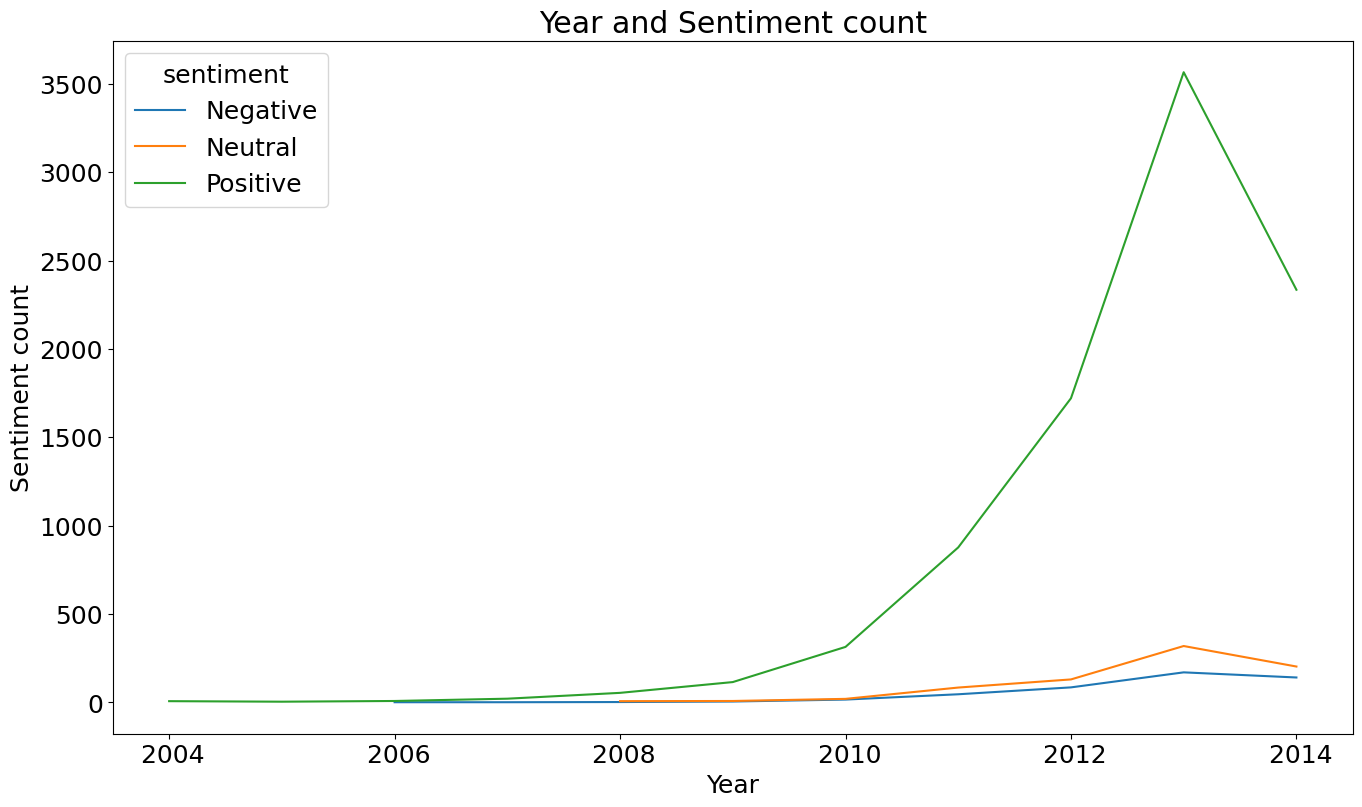

In [40]:
process_reviews.groupby(['year','sentiment'])['sentiment'].count().unstack().plot(legend=True)
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')
plt.show()

#### Insights:
#### From the plot we can clearly see the rise in positive reviews from 2010. Reaching its peak around 2013 and there is a dip in 2014, All the review rates were dropped at this time. Negative and neutral reviews are very low as compared to the positive reviews. Our second assumption is wrong !

### Each day vs Review count 

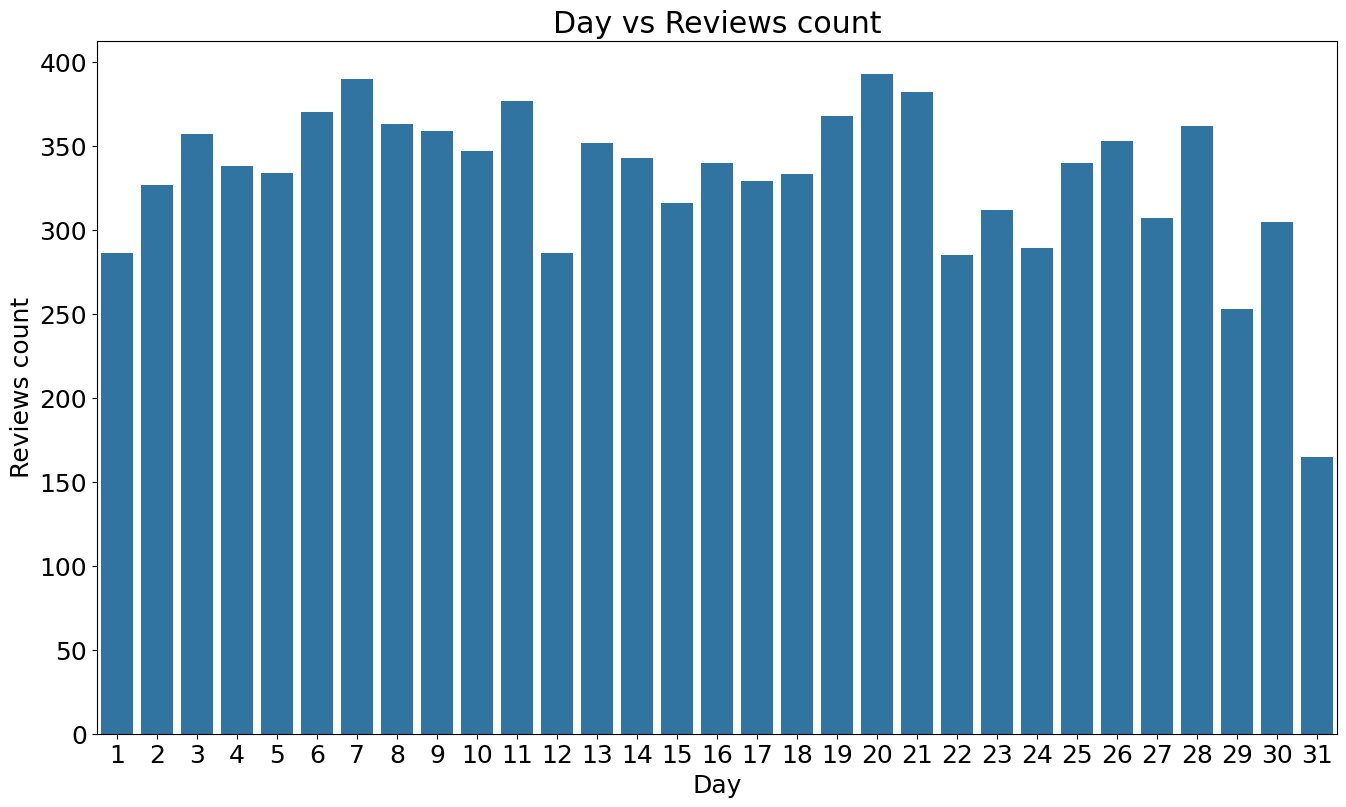

In [43]:
# Creating a dataframe 
day = pd.DataFrame(process_reviews.groupby('day')['reviews'].count()).reset_index()
day['day'] = day['day'].astype('int64')
day = day.sort_values(by= ['day'])

#plotting the graph
sns.barplot(x="day", y="reviews", data=day)
plt.title('Day vs Reviews count')
plt.xlabel('Day')
plt.ylabel('Reviews count')
plt.show()



#### Insights:
#### The review counts are more or less uniformly distributed.There isn't much variance between the days. But there is a huge drop at the end of month. Our third assumption is wrong ! 

### Feature Engineerig 

Now, let's create polarity, review length and word count:

- **Polarity:** We use Textblob to figure out the rate of sentiment. It is between [-1,1] where -1 is negative and 1 is positive polarity
- **Review length:** length of the review, which includes each letters and spaces
- **Word length:** This measures how many words are there in review

In [47]:
process_reviews['polarity'] = process_reviews['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)
process_reviews['review_len'] = process_reviews['reviews'].astype(str).apply(len)
process_reviews['word_count'] = process_reviews['reviews'].map(lambda x: len(str(x).split()))

In [48]:
process_reviews.head()

reviewerID        asin  overall  \
0  A2IBPI20UZIR0U  1384719342      5.0   
1  A14VAT5EAX3D9S  1384719342      5.0   
2  A195EZSQDW3E21  1384719342      5.0   
3  A2C00NNG1ZQQG2  1384719342      5.0   
4   A94QU4C90B1AX  1384719342      5.0   

                                             reviews sentiment   year month  \
0  Not much write here, but exactly supposed to. ...  Positive   2014    02   
1  The product exactly quite affordable.I not rea...  Positive   2013    03   
2  The primary job device block breath would othe...  Positive   2013    08   
3  Nice windscreen protects MXL mic prevents pops...  Positive   2014    02   
4  This pop filter great. It looks performs like ...  Positive   2014    02   

  day  helpful_rate  polarity  review_len  word_count  
0  28          0.00  0.250000         179          28  
1  16          0.93  0.052778         381          59  
2  28          1.00  0.167500         345          54  
3  14          0.00  0.250000         184          25  
4  21          0.00  0.800000         144          23

In [49]:
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

### Sentiment polarity distribution

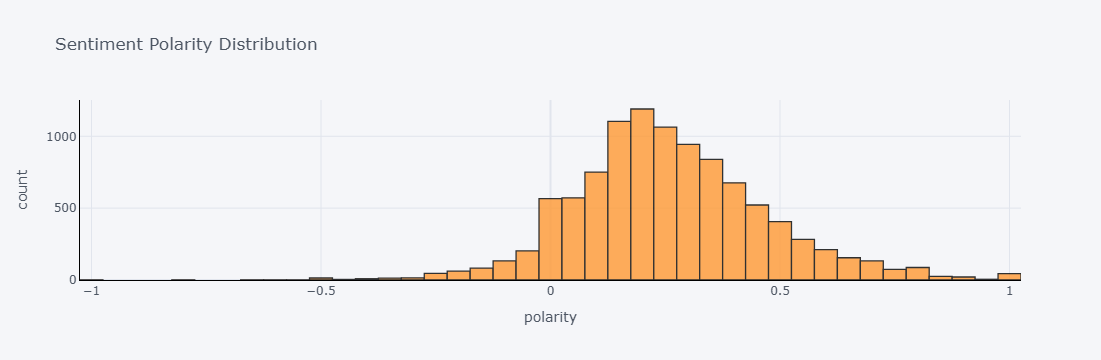

In [51]:
process_reviews['polarity'].iplot(
    kind='hist',
    bins=50,
    xTitle='polarity',
    linecolor='black',
    yTitle='count',
    title='Sentiment Polarity Distribution')
   

**Insights:**
- We have a lot of positive polarities compared to the negative polarities
- This polarity distributions assures the number of positive reviews we had
- We can say that this polarity is a normally distributed but not standard normal

### Review rating distribution

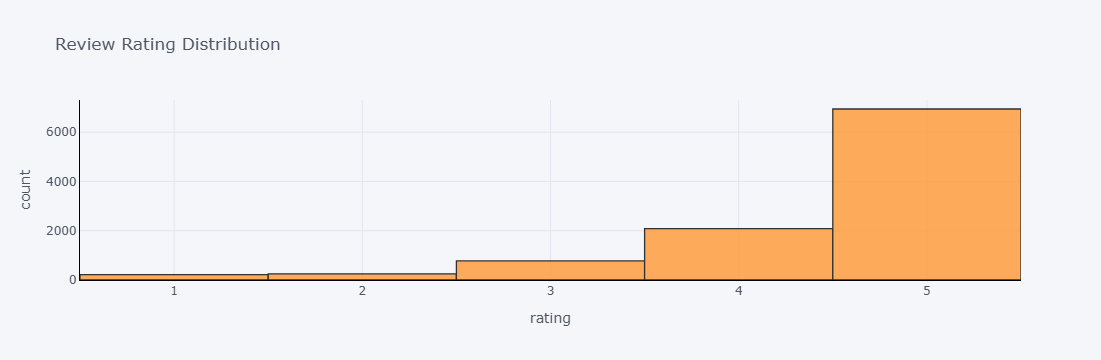

In [54]:
process_reviews['overall'].iplot(
    kind='hist',
    xTitle='rating',
    linecolor='black',
    yTitle='count',
    title='Review Rating Distribution')

- We have a large number of 5 ratings(nearly 7k) followed by 4,3,2,1. It's linear in nature

### Review text world count distribution

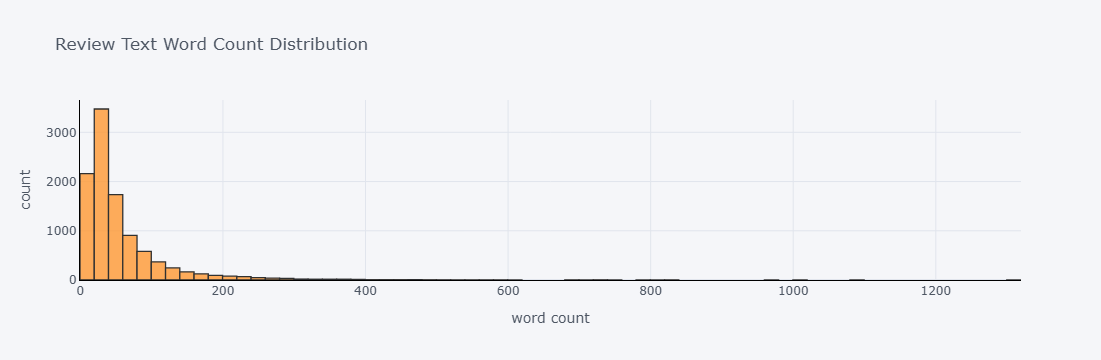

In [57]:
process_reviews['word_count'].iplot(
    kind='hist',
    bins=100,
    xTitle='word count',
    linecolor='black',
    yTitle='count',
    title='Review Text Word Count Distribution')

- We have a right skewed distribution with most of the words falling between 0-200 in a a review

### Review Text Length Distribution

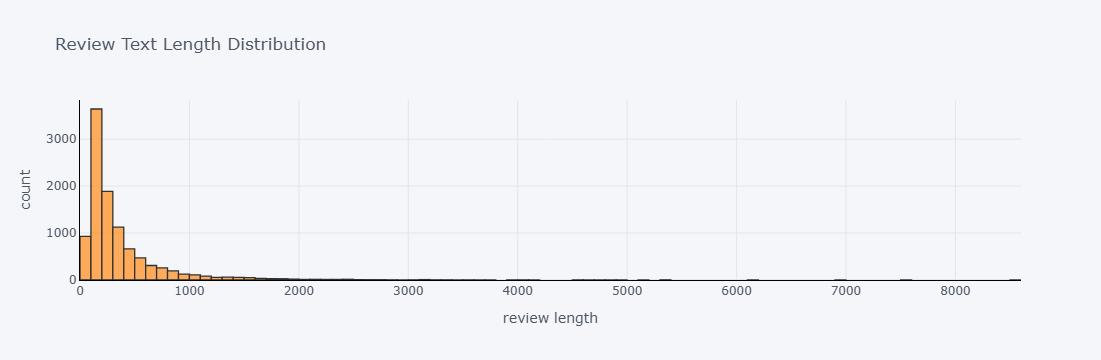

In [60]:
process_reviews['review_len'].iplot(
    kind='hist',
    bins=100,
    xTitle='review length',
    linecolor='black',
    yTitle='count',
    title='Review Text Length Distribution')

- We have a right skewed distribution where most of the lengths falls between 0-1000

### N-Gram analysis 

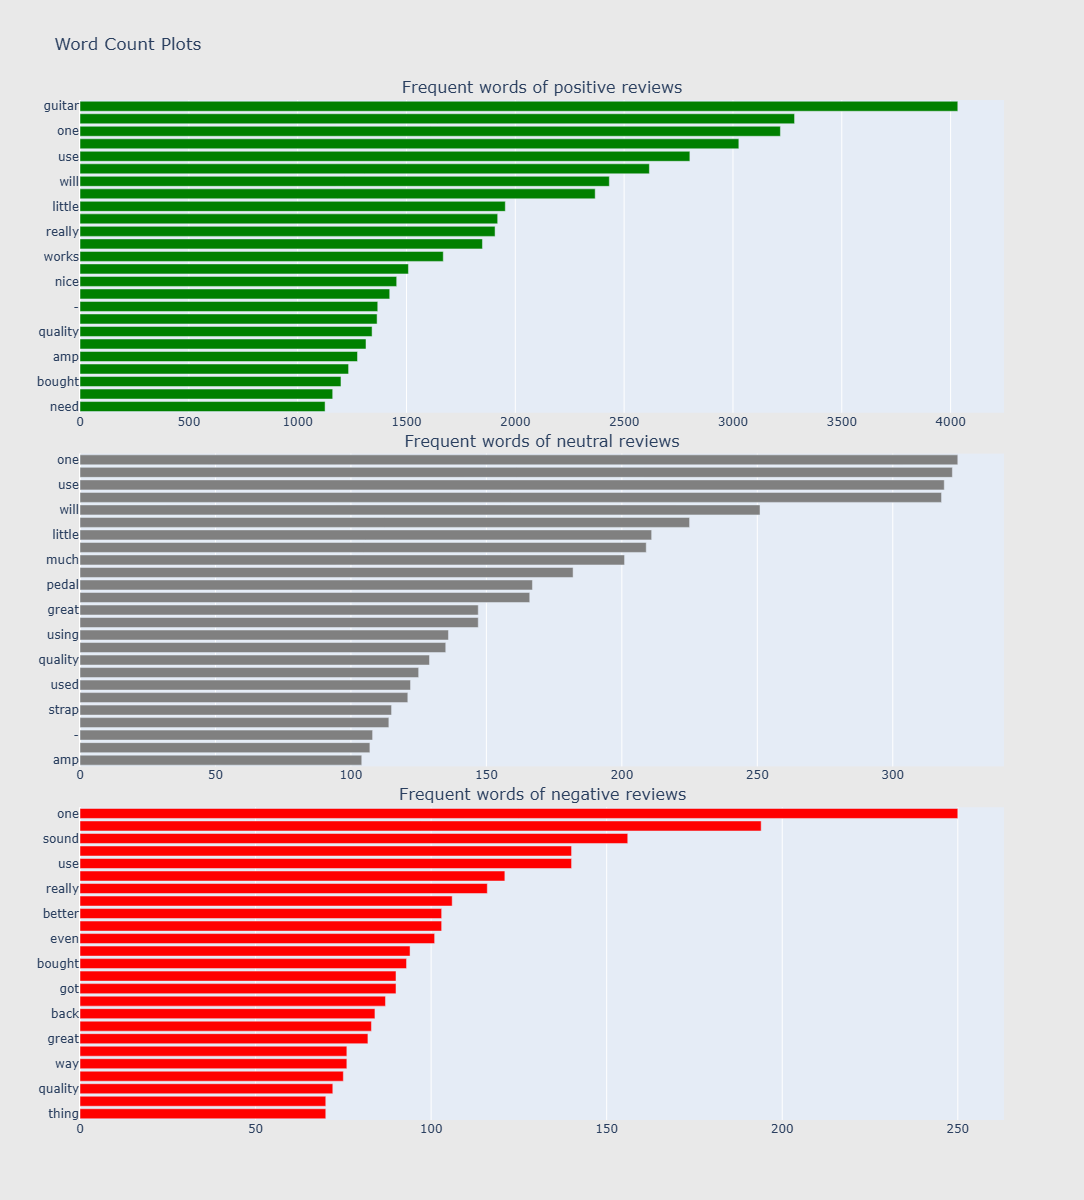

In [63]:
#Filtering data
review_pos = process_reviews[process_reviews["sentiment"]=='Positive'].dropna()
review_neu = process_reviews[process_reviews["sentiment"]=='Neutral'].dropna()
review_neg = process_reviews[process_reviews["sentiment"]=='Negative'].dropna()

## custom function for ngram generation ##
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != "" if token not in STOPWORDS]
    ngrams = zip(*[token[i:] for i in range(n_gram)])
    return [" ".join(ngram) for ngram in ngrams]

## custom function for horizontal bar chart ##
def horizontal_bar_chart(df, color):
    trace = go.Bar(
        y=df["word"].values[::-1],
        x=df["wordcount"].values[::-1],
        showlegend=False,
        orientation = 'h',
        marker=dict(
            color=color,
        ),
    )
    return trace

## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')

# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,
                          subplot_titles=["Frequent words of positive reviews", "Frequent words of neutral reviews",
                                          "Frequent words of negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=900, paper_bgcolor='rgb(233,233,233)', title="Word Count Plots")
iplot(fig, filename='word-plots')

#### As we see, the words doen't match with the sentiment except few. Through monogram we can't judge a sentiment based on one word. So let's try with frequent two words

### Bigram Analysis 

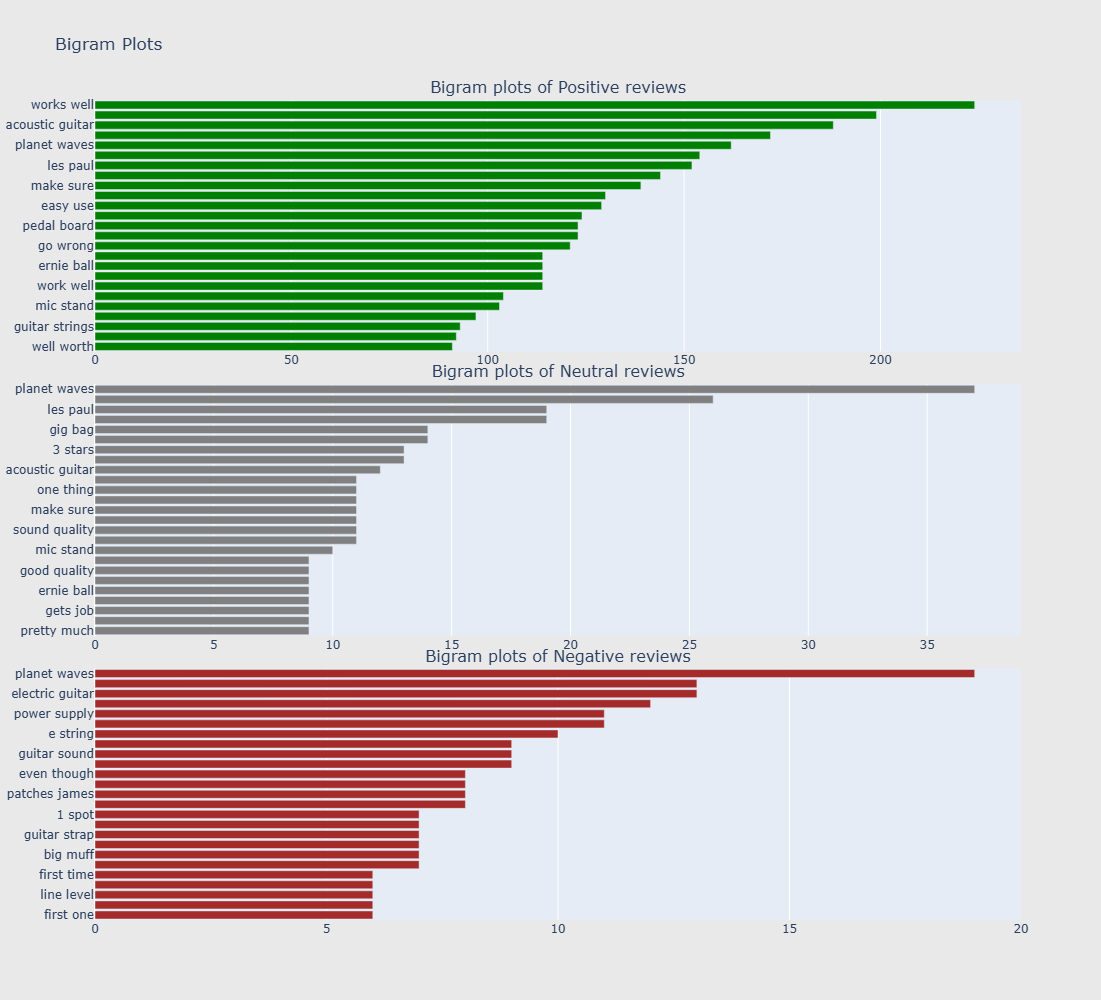

In [66]:
## Get the bar chart from positive reviews ##
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,2):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'brown')



# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04,horizontal_spacing=0.25,
                          subplot_titles=["Bigram plots of Positive reviews", 
                                          "Bigram plots of Neutral reviews",
                                          "Bigram plots of Negative reviews"
                                          ])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)


fig['layout'].update(height=1000, width=800, paper_bgcolor='rgb(233,233,233)', title="Bigram Plots")
iplot(fig, filename='word-plots')

##### Here we can get a clear idea about the sentiments from the bi-words

### Trigram analysis

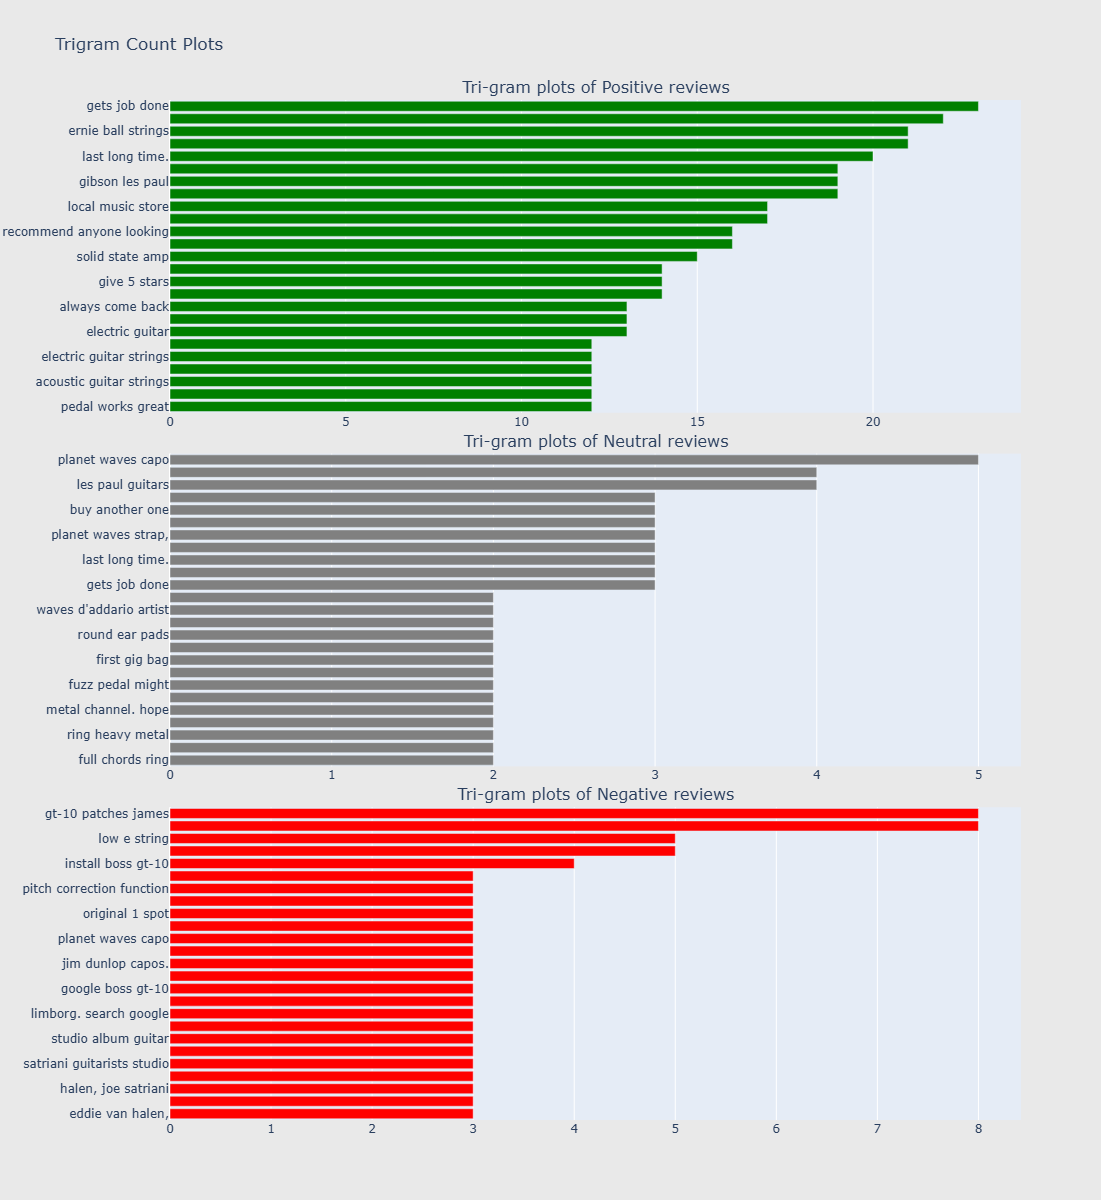

In [69]:
##### Get the bar chart from positive reviews ##
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace0 = horizontal_bar_chart(fd_sorted.head(25), 'green')

## Get the bar chart from neutral reviews ##
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace1 = horizontal_bar_chart(fd_sorted.head(25), 'grey')

## Get the bar chart from negative reviews ##
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent,3):
        freq_dict[word] += 1
fd_sorted = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1])[::-1])
fd_sorted.columns = ["word", "wordcount"]
trace2 = horizontal_bar_chart(fd_sorted.head(25), 'red')




# Creating two subplots
fig = tools.make_subplots(rows=3, cols=1, vertical_spacing=0.04, horizontal_spacing=0.05,
                          subplot_titles=["Tri-gram plots of Positive reviews", 
                                          "Tri-gram plots of Neutral reviews",
                                          "Tri-gram plots of Negative reviews"])
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 2, 1)
fig.append_trace(trace2, 3, 1)
fig['layout'].update(height=1200, width=1200, paper_bgcolor='rgb(233,233,233)', title="Trigram Count Plots")
iplot(fig, filename='word-plots') 

### Wordcloud-Positive reviews

#### Let's look at the word cloud of positive reviews

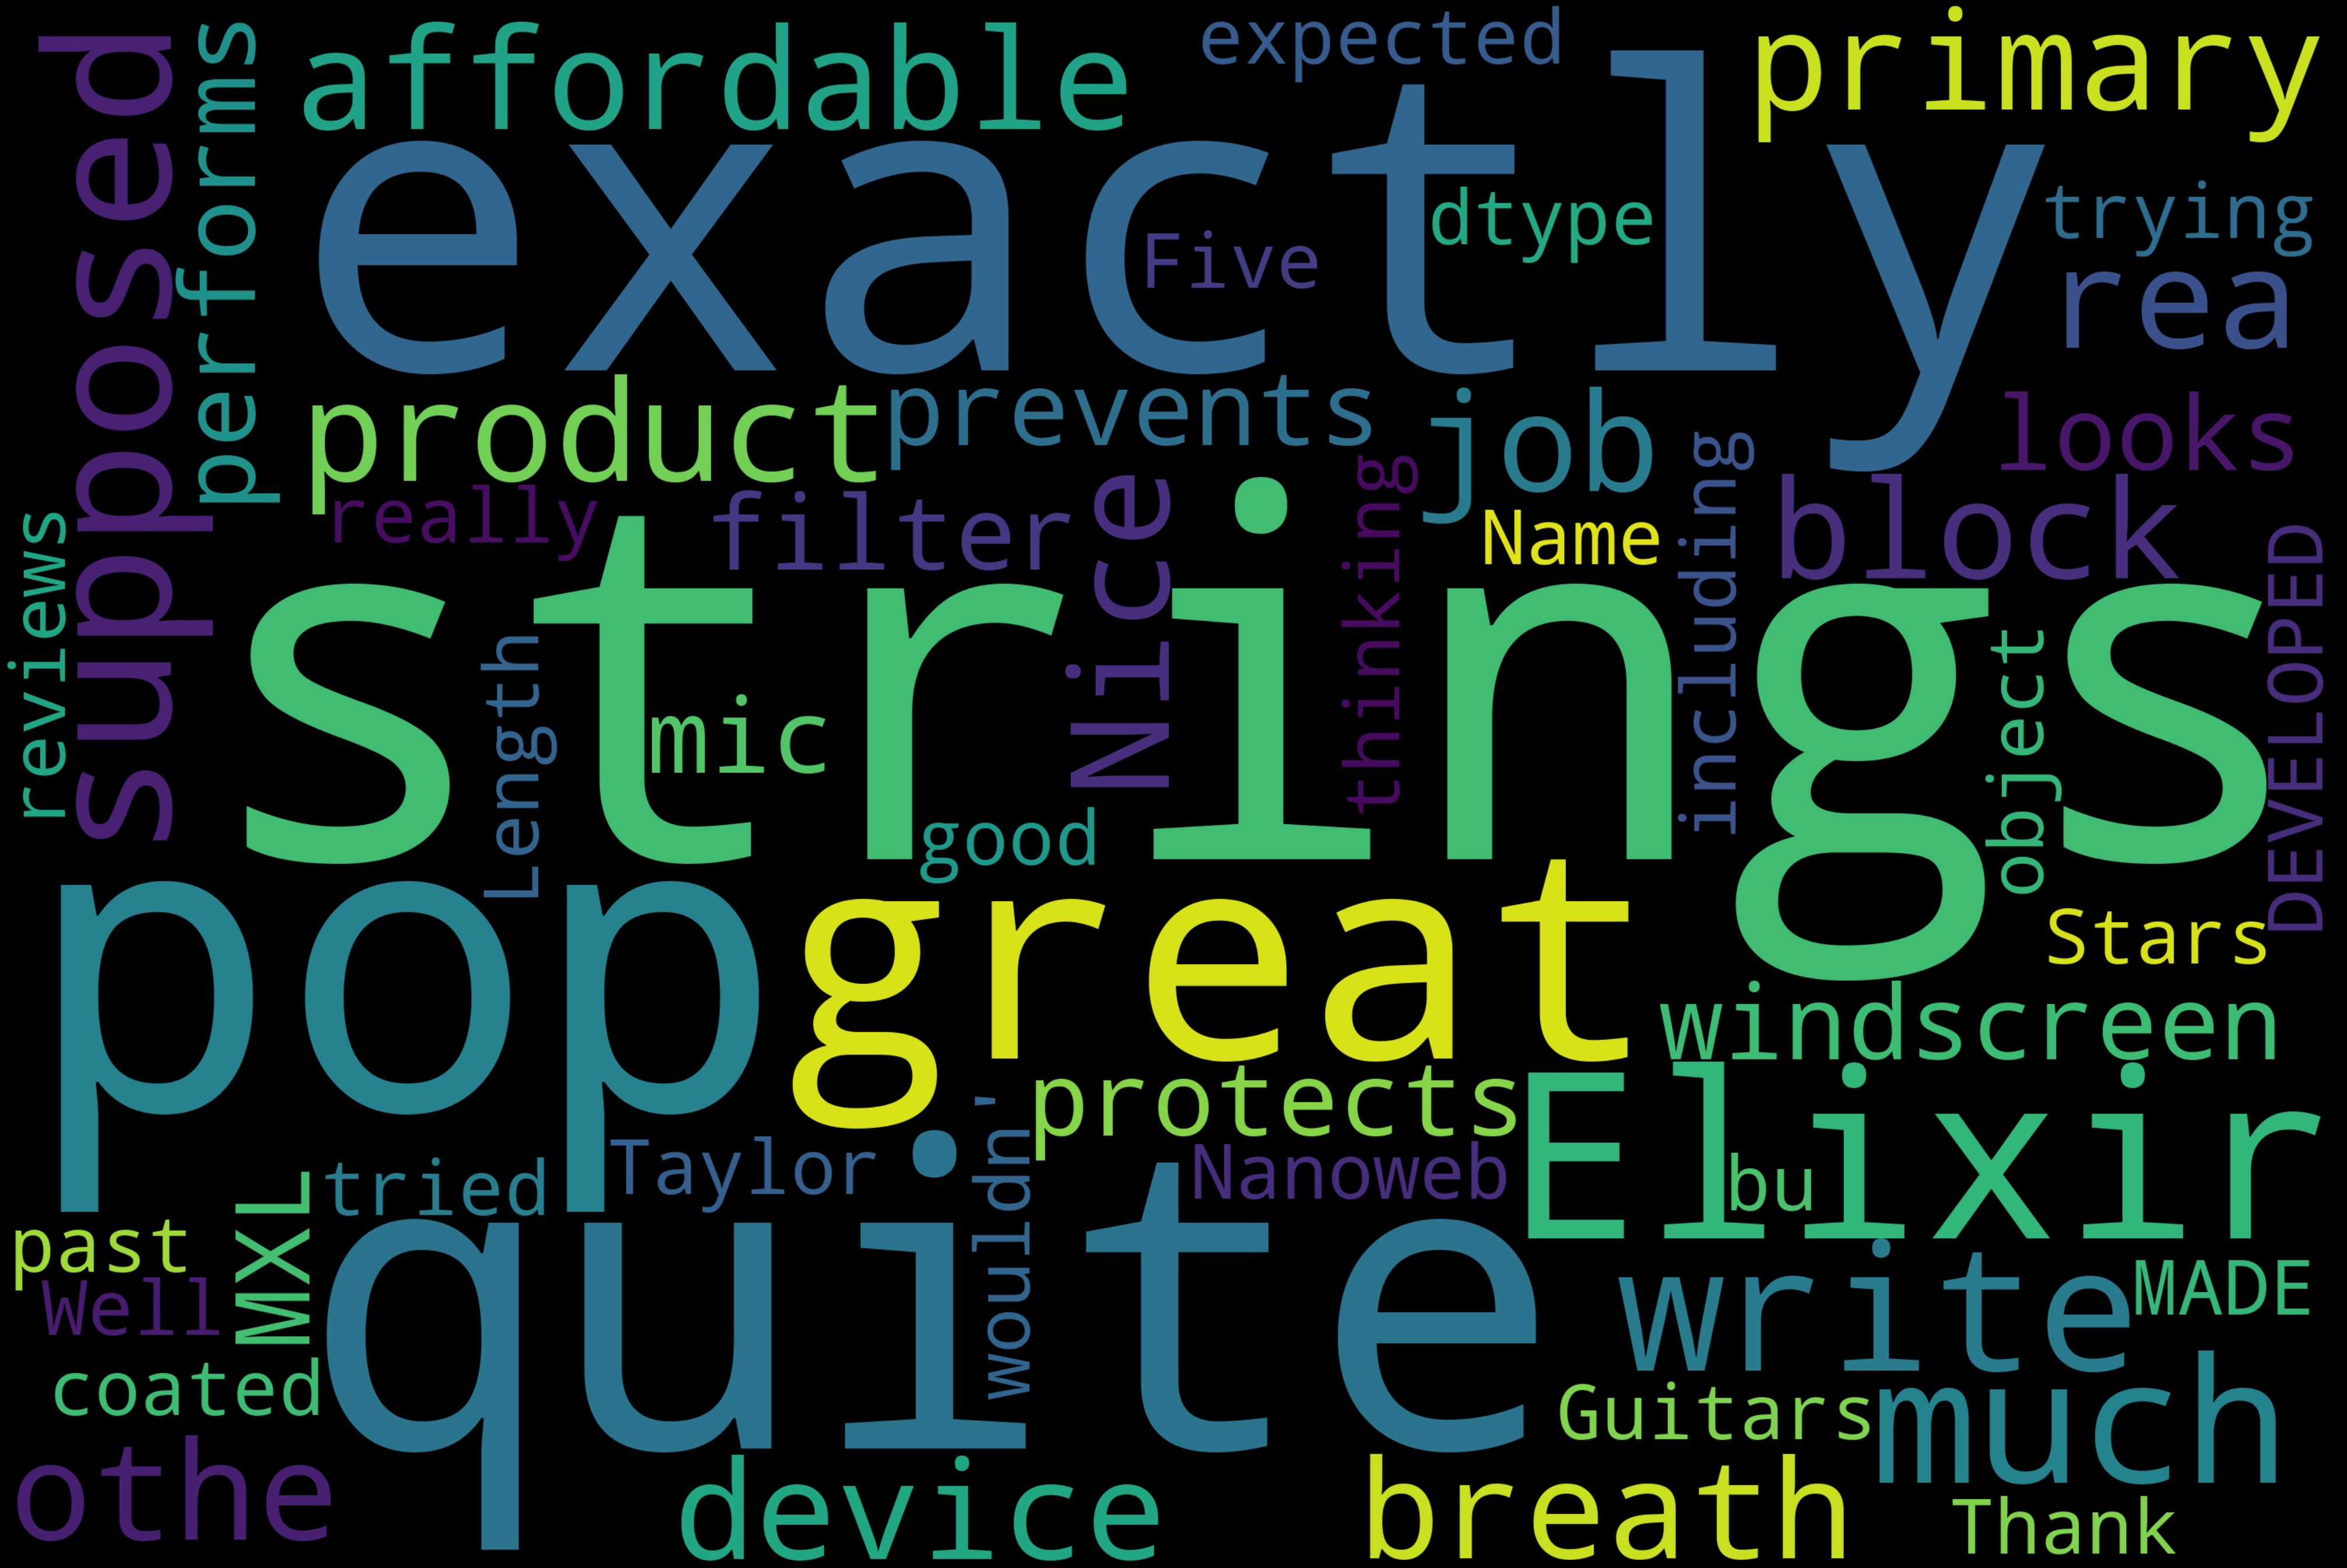

In [72]:
text = review_pos['reviews']
wordcloud = WordCloud(
    width = 3000, 
    height = 2000, 
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40,30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##### We can see positive words like great,affordable,expected,exactly etc.,

### Wordcloud-Neutral reviews

#### Let's look at the word cloud of neutral reviews

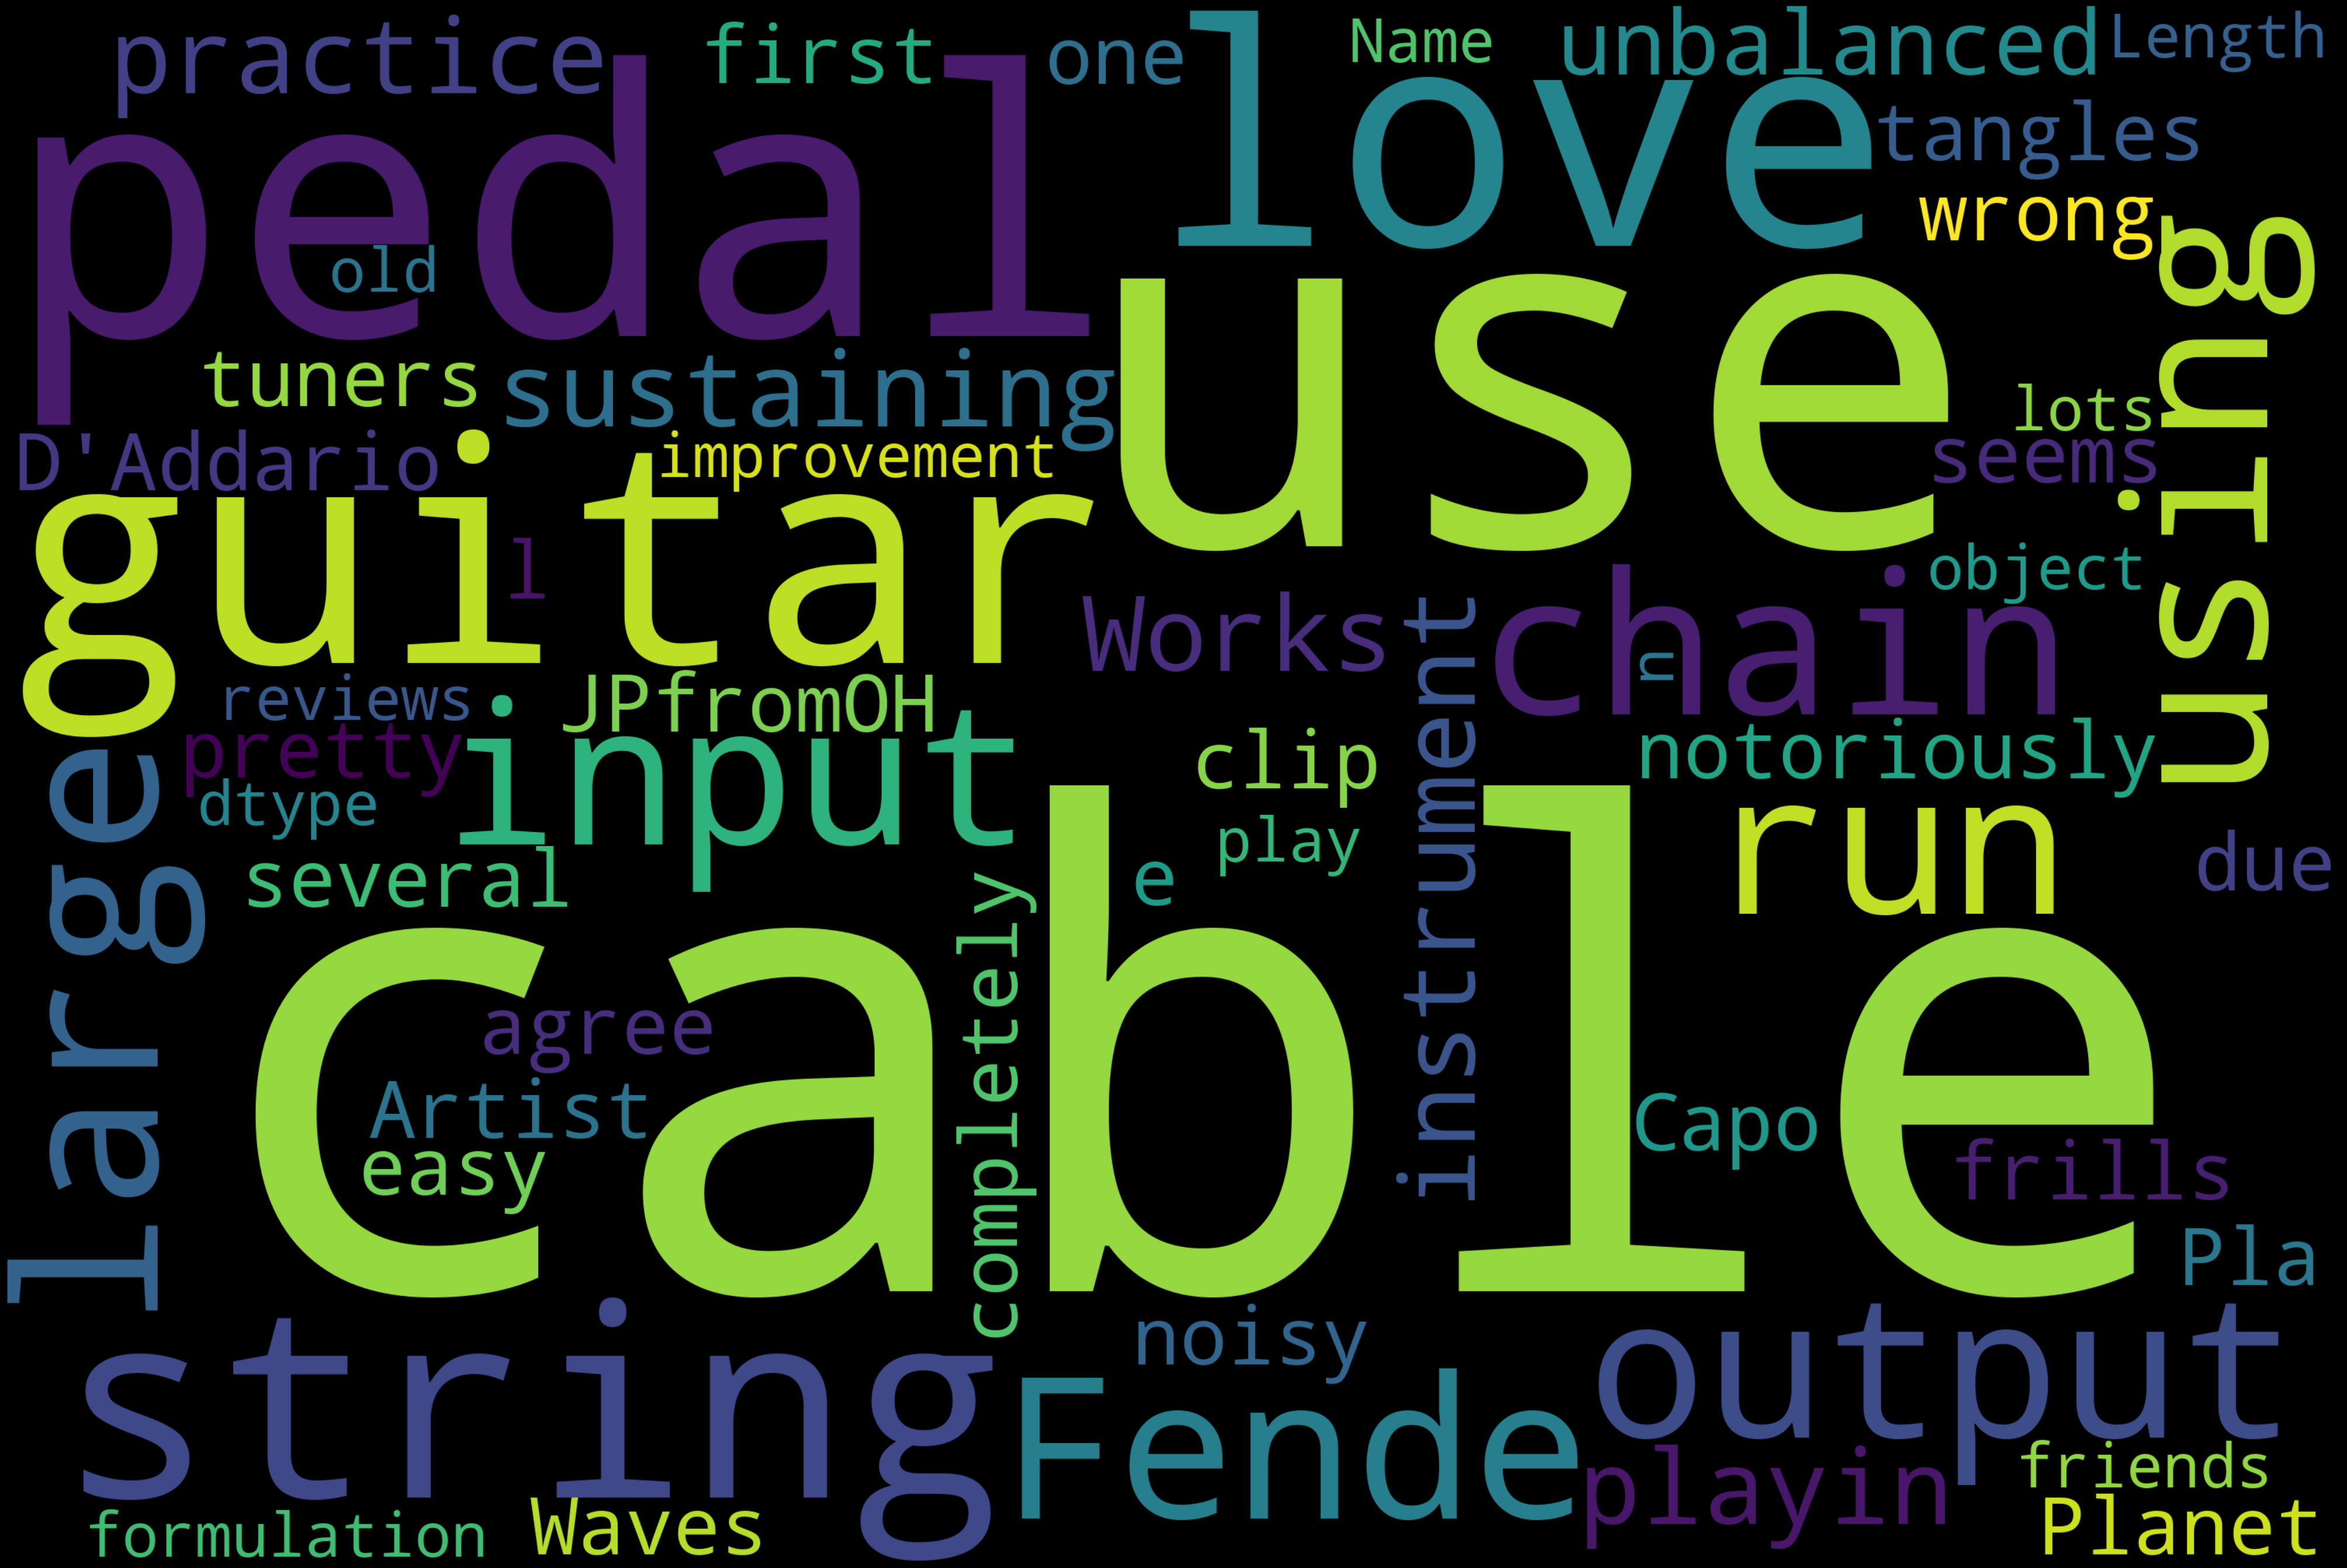

In [76]:
text = review_neu["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##### Most of the neutral review words are focussed on the products and how can they be improved.

### Wordcloud-Negative reviews

#### Let's look at the word cloud of negative reviews

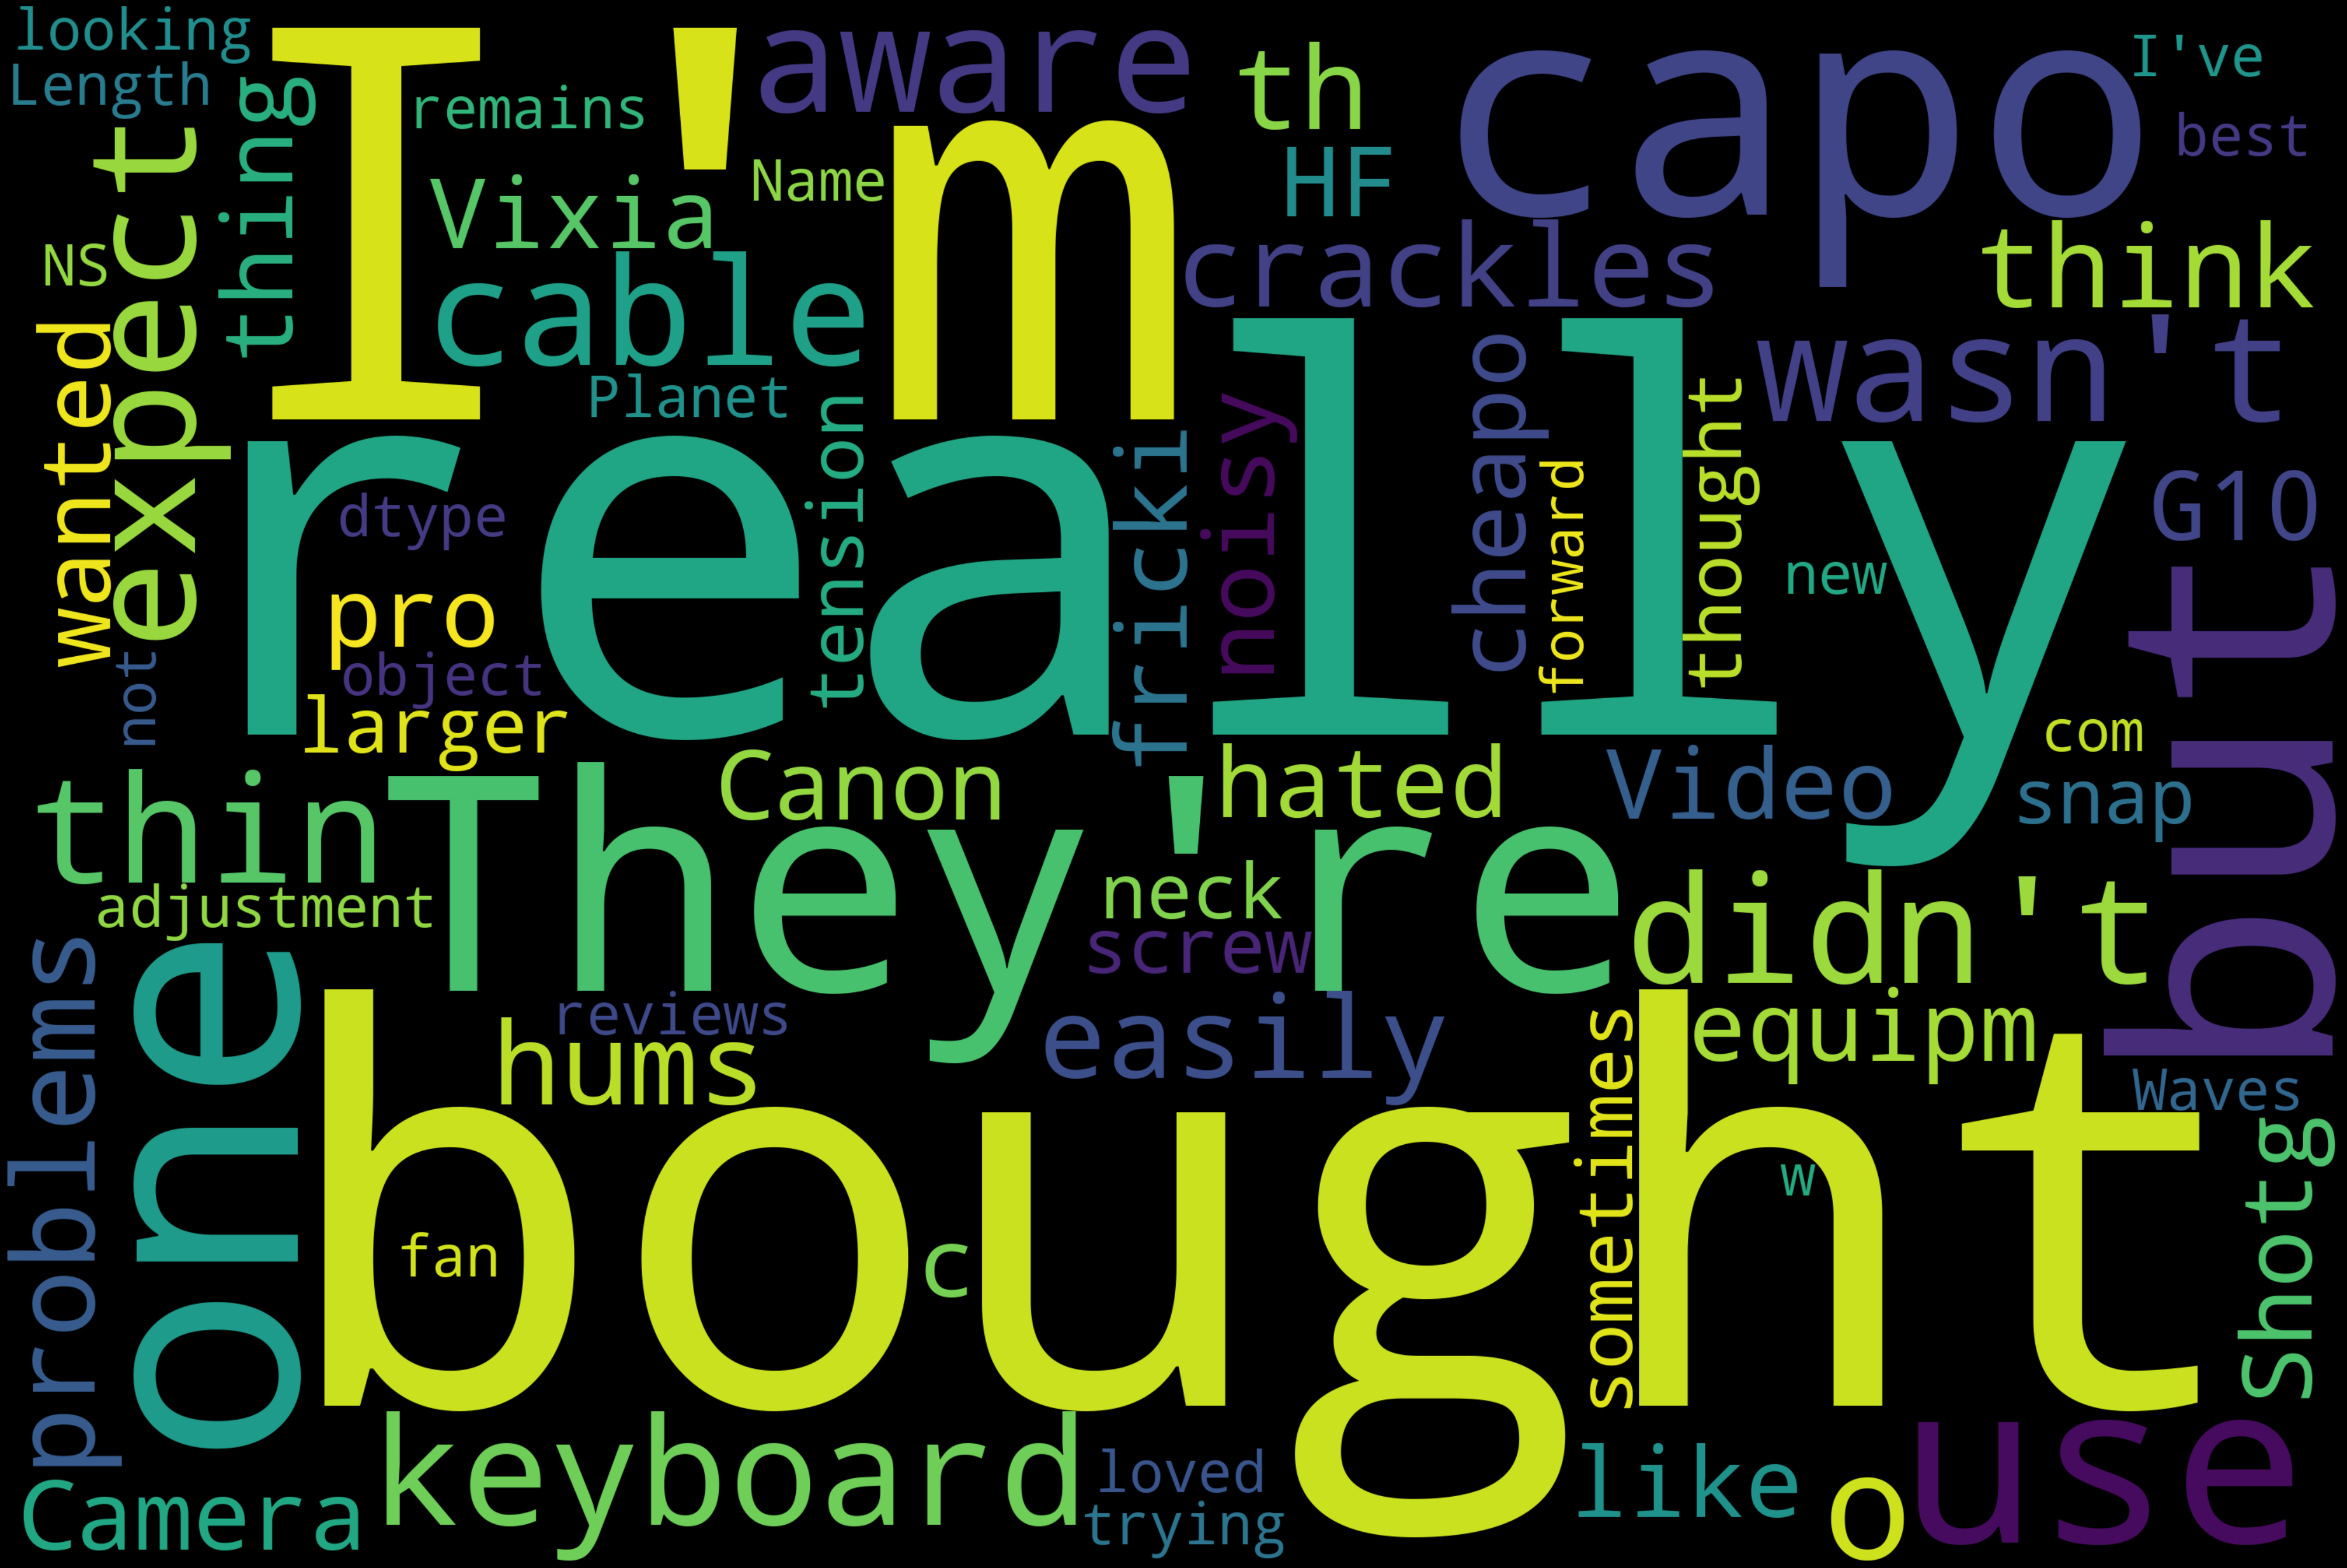

In [80]:
text = review_neg["reviews"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = stop_words).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

##### We can see negative review words such as noisy,didnt,frickin,wasnt,snap,problems,tension etc.,

### Encoding target variable: sentiment

In [263]:
# the label encoder function
label_encoder = preprocessing.LabelEncoder() 
  
# Encode labels in column 'sentiment'. 
process_reviews['sentiment']= label_encoder.fit_transform(process_reviews['sentiment']) 
  
process_reviews['sentiment'].unique() 

array([2, 1, 0], dtype=int64)

In [84]:
process_reviews['sentiment'].value_counts()

sentiment
2    9022
1     772
0     467
Name: count, dtype: int64

In [149]:
#### Stemming the reviews

In [151]:
#Extracting 'reviews' for processing
review_features=process_reviews.copy()
review_features=review_features[['reviews']].reset_index(drop=True)
review_features.head()

reviews
0  Not much write here, but exactly supposed to. ...
1  The product exactly quite affordable.I not rea...
2  The primary job device block breath would othe...
3  Nice windscreen protects MXL mic prevents pops...
4  This pop filter great. It looks performs like ...

In [153]:
# performing stemming on the review dataframe 
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(review_features)):
    review = re.sub('[^a-zA-Z]', ' ', review_features['reviews'][i])
    review = review.split()
    review = [ps.stem(word) for word in review if not word in stop_words]
    review = ' '.join(review)
    corpus.append(review)    


In [155]:
corpus[3]

'nice windscreen protect mxl mic prevent pop onli thing gooseneck margin abl hold screen posit requir care posit clamp avoid sag good windscreen for the money'

##### This is how a line looks like now, as computer cannot understand words and their sentiment we need to convert these words into 1's and 0's. To encode it we use TFIDF

### TFIDF(Term Frequency — Inverse Document Frequency)

#### TF-IDF stands for “Term Frequency — Inverse Document Frequency”. This is a technique to quantify a word in documents; we generally compute a weight to each word which signifies the importance of the word in the document and corpus. This method is a widely used technique in Information Retrieval and Text Mining.

#### Here we are splitting as bigram (two words) and consider their combined weight.Also we are taking only the top 5000 words from the reviews.

In [163]:
tfidf_vectorizer = TfidfVectorizer(max_features = 5000, ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(review_features['reviews'])

In [165]:
X.shape

(10261, 5000)

In [167]:
#Getting the target variable(encoded)
y=process_reviews['sentiment']

### Handling Imbalance target feature-SMOTE

#### In our target feature, we noticed that we got a lot of positive sentiments compared to negative and neutral. So it is crucial to balance the classes in such situatio. Here I use SMOTE(Synthetic Minority Oversampling Technique) to balance out the imbalanced dataset problem.It aims to balance class distribution by randomly increasing minority class examples by replicating them.

#### SMOTE synthesises new minority instances between existing minority instances. It generates the virtual training records by linear interpolation for the minority class. These synthetic training records are generated by randomly selecting one or more of the k-nearest neighbors for each example in the minority class. After the oversampling process, the data is reconstructed and several classification models can be applied for the processed data.

In [173]:
print(f'Original dataset shape : {Counter(y)}')

smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y)

print(f'Resampled dataset shape {Counter(y_res)}')

Original dataset shape : Counter({2: 9022, 1: 772, 0: 467})
Resampled dataset shape Counter({2: 9022, 1: 9022, 0: 9022})


### Train/ Test Split 

In [176]:
## Divide the dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.25, random_state=0)

### Modeling 

#### First select the best peforming model by using cross validaton. Let's consider all the classification algorithm and perform the model selection process

In [187]:
logreg_cv = LogisticRegression(random_state=0)
dt_cv=DecisionTreeClassifier()
knn_cv=KNeighborsClassifier()
svc_cv=SVC()
nb_cv=BernoulliNB()
cv_dict = {0: 'Logistic Regression', 1: 'Decision tree', 2: 'KNN', 3: 'SVC', 4: 'Naive Bayes'}
cv_models = [logreg_cv, dt_cv, knn_cv, svc_cv, nb_cv]

for i,model in enumerate(cv_models):
    print("{} Test Accuracy {}".format(cv_dict[i], cross_val_score(model, X, y, cv=10, scoring = 'accuracy').mean()))


Logistic Regression Test Accuracy 0.8827600213343052
Decision tree Test Accuracy 0.8309137687885189
KNN Test Accuracy 0.8765223943771578
SVC Test Accuracy 0.8802260980808615
Naive Bayes Test Accuracy 0.8066441935196099


From the results, we can see that **Logistic Regression** is the best performing model. Therefore, applying hyperparameter tuning to Logistic Regression

### Logistic Regression with Hyperparameter Tuning

In [196]:
param_grid = {'C': np.logspace(-4, 4, 50),
             'penalty':['l1', 'l2']}
clf = GridSearchCV(LogisticRegression(random_state=0), param_grid,cv=5, verbose=0,n_jobs=-1)
best_model = clf.fit(X_train,y_train)
print(best_model.best_estimator_)
print("The mean accuracy of the model is:",best_model.score(X_test,y_test))  

LogisticRegression(C=6866.488450042998, random_state=0)
The mean accuracy of the model is: 0.9541894487956258


In [198]:
logreg = LogisticRegression(C=10000.0, random_state=0)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.96


The accuracy of the model is 96%. However, we need to focus on the confusion matrix and f1 for classification-related issues. 

### Classification matrix 

In [204]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i in range (cm.shape[0]):
        for j in range (cm.shape[1]):
            plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization


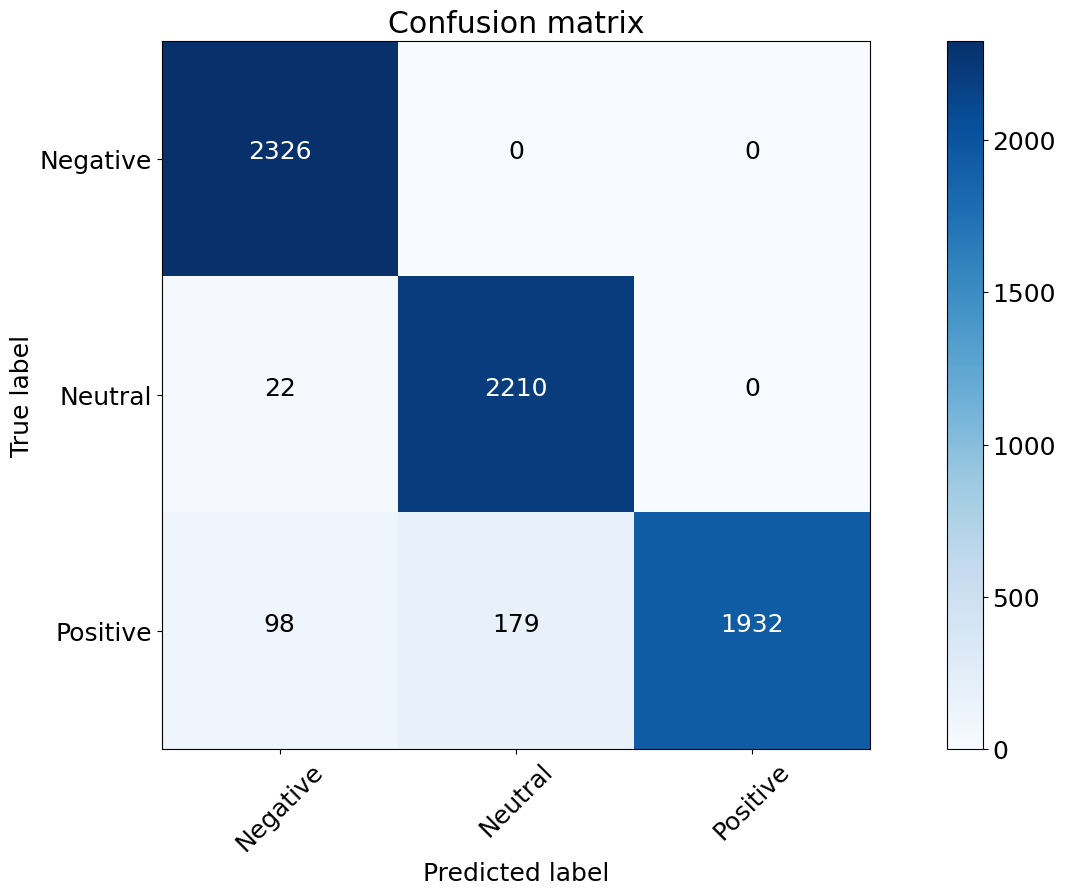

In [206]:
cm = metrics.confusion_matrix(y_test, y_pred)
plot_confusion_matrix(cm, classes=['Negative','Neutral','Positive'])

In [208]:
print("Classification Report:\n",classification_report(y_test, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      2326
           1       0.93      0.99      0.96      2232
           2       1.00      0.87      0.93      2209

    accuracy                           0.96      6767
   macro avg       0.96      0.95      0.95      6767
weighted avg       0.96      0.96      0.96      6767



##### Here, we achieved a strong F1 score.

### ROC AUC Score

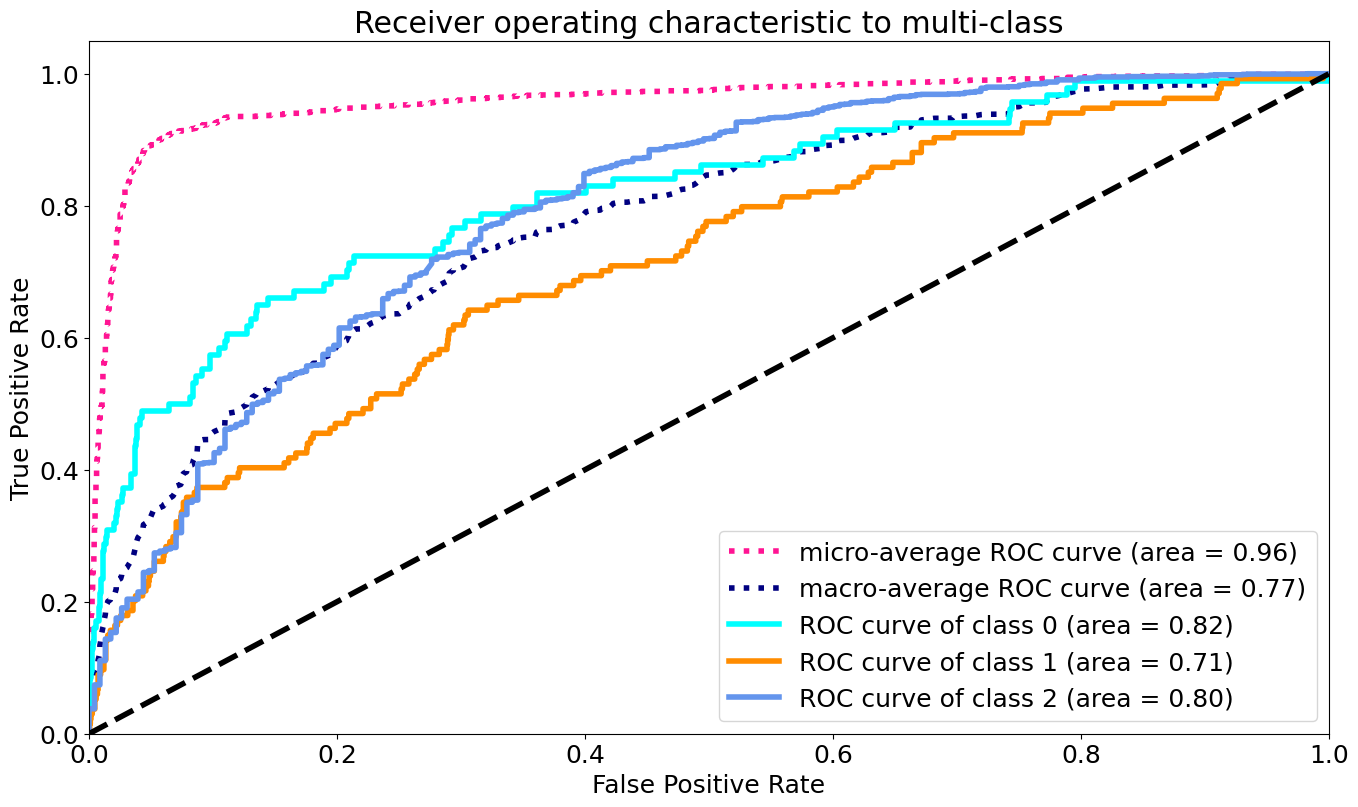

In [220]:
#Binarizing the target feature
y = label_binarize(y, classes=[0, 1, 2])
n_classes = y.shape[1]

#Train-Test split(80:20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2,
                                                    random_state=0)

#OneVsRestClassifier
classifier = OneVsRestClassifier(svm.SVC(kernel='linear', probability=True,
                                 random_state=10))
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

#Computing TPR and FPR
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
# aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=4,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=4)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

**Insights:**
- Considering the ROC curve for classes, classes 2 and 0 have been classified pretty well, and their area under the curve is high. We can choose any threshold between 0.6-0.8 to get the optimal number of TPR and FPR
- Micro average performs really well, and macro average is not performing well.

### Conclusion:

- **Data Preparation and Handling:** The process included splitting sentiments based on the overall score, cleaning the text, and customizing the stopword list to meet specific requirements.
- **Stopword Handling:** Standard stopword lists were avoided in sentiment analysis as they included words with negative connotations, which could have distorted the results. The stopword list was manually reviewed and adjusted for better accuracy.
- **N-gram Utilization:** Incorporating n-grams (e.g., bi-grams, tri-grams) significantly improved the accuracy of the sentiment analysis. Single words often failed to capture the contextual meaning effectively.
- **Neutral Sentiment Insights:** A large proportion of neutral reviews in the dataset turned out to be constructive critiques of products.
- **Recommendation:** Amazon could consider leveraging such neutral reviews as actionable feedback for sellers to improve their products.
- **Dataset Composition:** Most reviews in the dataset were related to string instruments, such as guitars, highlighting a potential niche focus.
- **Addressing Class Imbalance:** SMOTE (Synthetic Minority Oversampling Technique) was used to balance the dataset, resulting in significantly improved recall and F1 score.
- **Observation:** Before balancing, precision was good, but recall was low, which negatively impacted the F1 score. Balancing the target feature proved essential for robust performance.
- **Performance Metrics:** The F1 score was prioritized as the primary metric for evaluating the sentiment analysis model.
The analysis achieved an impressive average **F1 score of 96%**, indicating a high level of accuracy and balance in the classification results.